In [2]:
import cv2 # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plotting
import math

In [3]:
# Constants
MAZE_FILE_NAME = "../Maze.png"
ROBOT_FILE_NAME = "../Robot.png"
IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'
MAP_FILE_NAME = '../MapBuilt.txt'
MAZE_VIDEO_PATH = "../MTRN4110_PhaseD.mp4"

In [4]:
# 3.1 Read in an image and display it in RGB mode

def task1(plot=False):
    maze_img = cv2.cvtColor(cv2.imread(MAZE_FILE_NAME), cv2.COLOR_BGR2RGB) # OpenCV reads an image in the BGR order by default
    robot_img = cv2.cvtColor(cv2.imread(ROBOT_FILE_NAME), cv2.COLOR_BGR2RGB)
    target_img = cv2.cvtColor(cv2.imread(IMAGE_LADYBUG_FILE_NAME), cv2.COLOR_BGR2RGB)
    
    
    if plot:
        plt.figure(figsize = (10, 10))
        plt.imshow(maze_img), plt.axis('off'), plt.title(f"Task 1 - Display image"), plt.show()
    return maze_img, robot_img, target_img

# maze_img, robot_img, target_img = task1(plot=True)

In [5]:
#3.2. Find the four ordered cornerstones of the maze
def task2(maze_img, plot=False):
    # Convert image to HSV colourspace
    maze_cp = np.copy(maze_img)
    maze_hsv = cv2.cvtColor(maze_cp, cv2.COLOR_RGB2HSV)

    # Set minimum and maximum HSV values for cyan to display
    low_cyan = np.array([80,40,230])
    high_cyan = np.array([100, 255, 255])

    # Set minimum and maximum HSV values for pink to display
    low_pink = np.array([140,200,200])
    high_pink = np.array([170, 255, 255])

    # Convert to HSV format and color threshold
    cyan_mask = cv2.inRange(maze_hsv, low_cyan, high_cyan)
    pink_mask = cv2.inRange(maze_hsv, low_pink, high_pink)

    kernel = np.ones((3,3), np.uint8)
    pink_mask_opened = cv2.morphologyEx(pink_mask, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((3,3), np.uint8)
    pink_mask_final = cv2.morphologyEx(pink_mask_opened, cv2.MORPH_CLOSE, kernel)

    _, cyan_contours, _ = cv2.findContours(cyan_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    _, pink_contours, _ = cv2.findContours(pink_mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    centers = []
    for c in cyan_contours:
        if len(c) >= 5:
            e = cv2.fitEllipse(c)
            centers.append(e[0])
            cv2.ellipse(maze_cp, e, (243, 25, 245), 3)
            # cv2.ellipse(maze_cp, e, (0,215, 255), 3)


    for c in pink_contours:
        if len(c) >= 5:
            e = cv2.fitEllipse(c)
            centers.append(e[0])
            cv2.ellipse(maze_cp, e, (120, 243, 245), 3)
            # cv2.ellipse(maze_cp, e, (0, 128, 0), 3)

    centers = np.float32(centers)

    # Define cornerstone regions
    regionA = [[0, 0], [375, 337.5]]
    regionB = [[30, 1012.5], [375, 1350]]
    regionC = [[375, 0], [750, 337.5]]
    regionD = [[375, 1012.5], [750, 1350]]
    # # Re-order centers for perspective transform
    ordered_centers = []
    flipped = False
    if inRegion(centers[0], regionA):
        ordered_centers = orderPoints(centers, 'A')
    else:
        ordered_centers = orderPoints(centers, 'D')
        flipped = True

    
    if plot:
        # Plot maze with circles on cornerstones
        plt.figure(figsize = (10, 10))
        plt.plot(), plt.imshow(maze_cp), plt.axis('off'), plt.title("Task 2 - Display maze corners")
        plt.show()
        
        # plt.imshow(cyan_mask, cmap='gray')
        # plt.show()

    return maze_cp, ordered_centers, flipped

# Checks if given point lies within given region
def inRegion(point, region):
    top, left = region[0]
    bottom, right = region[1]
    x, y = point
    if top <= y <= bottom and left <= x <= right: 
        return True

    return False

# Orders the points for perspective transformation
def orderPoints(points, region):
    rect = np.zeros((4, 2), dtype = "float32")
    s = points.sum(axis = 1)
    rect[0] = points[np.argmin(s)]
    rect[3] = points[np.argmax(s)]
    diff = np.diff(points, axis = 1)
    rect[1] = points[np.argmin(diff)]
    rect[2] = points[np.argmax(diff)]
    if region is 'D':
        rect = np.array((rect[3],rect[2],rect[1],rect[0]))

    return rect

# maze_corners, corners, flipped = task2(maze_img, plot=True)

In [6]:
#3.3 PERSPECTIVE TRANSFORM THE MAZE FROM THE ORIGINAL IMAGE TO A RECTANGLE IMAGE

def task3(maze_corners, corners, plot=False):
    #find the coordinates of the gemstones
    maze_image_with_gemstones_rgb_copy = maze_corners.copy()
    cyan_centroid_x = 0
    cyan_centroid_y = 0
    cyan_and_pink_corners = []

    height = 500
    width = int(9 * height/5) 
    top_left_corner_boundary = 337.5
    corners1 = np.float32(corners)
    dimensions = [[0, 0], [width,0], [0, height], [width,height]]
        
    corners2 = np.float32(dimensions)
    H = cv2.getPerspectiveTransform(corners1,corners2) # homography matrix
    maze_image_transformed = cv2.warpPerspective(maze_image_with_gemstones_rgb_copy , H, (width,height))
    
    if plot:
        plt.figure(figsize = (10, 10))
        plt.plot(), plt.imshow(maze_image_transformed), plt.axis('off'), plt.title("Task 3 - Transform the maze perspective"), plt.show()
    
    return maze_image_transformed

# maze_transformed = task3(maze_corners, corners, plot=True)

In [7]:
#3.4 DETECT ALL THE INTERNAL WALLS
def task4(maze_image_transformed, plot=False):
    # Set minimum and maximum HSV values for pink to display
    maze_hsv = cv2.cvtColor(maze_image_transformed, cv2.COLOR_RGB2HSV)
    maze_image_transformed_copy = np.copy(maze_image_transformed)
    # print(maze_image_transformed_copy.shape)
    walls = np.zeros(maze_image_transformed_copy.shape, dtype = "uint8")
    # walls = cv2.cvtColor(walls, cv2.COLOR_RGB2GRAY)
    # print(walls[0][0])
    wall_lower = np.array([17,30, 220])
    wall_upper = np.array([20, 255, 255])

    kernel = np.ones((6,6), np.uint8)
    wall_mask = cv2.inRange(maze_hsv , wall_lower, wall_upper)
    wall_mask_opened = cv2.morphologyEx(wall_mask, cv2.MORPH_OPEN, kernel)
    _, wall_contours, _ = cv2.findContours(wall_mask_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    robot_marker_x_values = []
    robot_marker_y_values = []

    for wall in wall_contours:
        i = 0
        robot_marker_x_values.clear()
        robot_marker_y_values.clear()
        while (i < len(wall)):
            robot_marker_x_values.append(wall[i][0][0])
            robot_marker_y_values.append(wall[i][0][1])
            i += 1
        x_min = min(robot_marker_x_values)
        x_max = max(robot_marker_x_values)
        y_min = min(robot_marker_y_values)
        y_max = max(robot_marker_y_values)
        if y_min + 50 > y_max:
            cv2.line(walls, (x_min, int((y_min + y_max)/2)), (x_max, int((y_min + y_max)/2)), (0,0,255), 5)
            cv2.line(maze_image_transformed_copy, (x_min, int((y_min + y_max)/2)), (x_max, int((y_min + y_max)/2)), (0,0,255), 5)
        else:
            cv2.line(walls, (int((x_min + x_max)/2), y_min), (int((x_min + x_max)/2), y_max), (0,0,255), 5)   
            cv2.line(maze_image_transformed_copy, (int((x_min + x_max)/2), y_min), (int((x_min + x_max)/2), y_max), (0,0,255), 5)      

    # print(np.walls)
    if plot:
        plt.figure(figsize = (10, 10))
        plt.plot(), plt.imshow(maze_image_transformed_copy), plt.axis('off'), plt.title("Task 4 - Detect internal walls"), plt.show()


    return maze_image_transformed_copy, walls

# maze_walls, wall_mask = task4(maze_transformed, plot=True)


In [8]:
#3.5 DETECT THE LOCATION AND HEADING OF THE ROBOT

def task5(maze_img, robot_img, flipped, plot=False):
    # Generate an ArUco marker for use
    # Load the predefined dictionary
    # dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)

    # Generate the marker
    # markerImage = np.zeros((200, 200), dtype=np.uint8)
    # markerImage = cv2.aruco.drawMarker(dictionary, 33, 200, markerImage, 1)

    # ROBOT_FILE_NAME_rgb_origin = cv2.cvtColor(ROBOT_FILE_NAME,cv2.COLOR_BGR2RGB)
    # ROBOT_FILE_NAME_rgb = cv2.cvtColor(ROBOT_FILE_NAME,cv2.COLOR_BGR2RGB)
    
    robot_img_bgr = cv2.cvtColor(robot_img, cv2.COLOR_RGB2BGR)
    maze_image_transformed = np.copy(maze_img)
    # Load the predefined dictionary
    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)

    # Initialize the detector parameters using default values
    parameters =  cv2.aruco.DetectorParameters_create()

    # Detect the markers in the image
    markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(robot_img_bgr, dictionary, parameters=parameters)
    robot_marker_x_values= []
    robot_marker_y_values = []
    robot_marker_top_left_x = markerCorners[0][0][0][0]
    robot_marker_x_values.append(robot_marker_top_left_x)
    robot_marker_top_left_y = markerCorners[0][0][0][1]
    robot_marker_y_values.append(robot_marker_top_left_y)
    robot_marker_top_right_x = markerCorners[0][0][1][0]
    robot_marker_x_values.append(robot_marker_top_right_x)
    robot_marker_top_right_y = markerCorners[0][0][1][1]
    robot_marker_y_values.append(robot_marker_top_right_y)
    robot_marker_bottom_right_x = markerCorners[0][0][2][0]
    robot_marker_x_values.append(robot_marker_bottom_right_x)
    robot_marker_bottom_right_y = markerCorners[0][0][2][1]
    robot_marker_y_values.append(robot_marker_bottom_right_y)
    robot_marker_bottom_left_x = markerCorners[0][0][3][0]
    robot_marker_x_values.append(robot_marker_bottom_left_x)
    robot_marker_bottom_left_y = markerCorners[0][0][3][1]
    robot_marker_y_values.append(robot_marker_bottom_left_y)

    robot_marker_x_values.sort()
    robot_marker_y_values.sort()
    #check orientation
    if (robot_marker_top_left_x == min(robot_marker_x_values)):
        if flipped == False:
            heading = '<'
        elif flipped == True:
            heading = '>'
    elif (robot_marker_top_left_x == max(robot_marker_x_values)):
        if flipped == False:
            heading = '>'
        elif flipped == True:
            heading = '<'
    elif (robot_marker_top_left_y == max(robot_marker_y_values)):
        if flipped == False:
            heading = 'v'
        elif flipped == True:
            heading = '^'
    elif (robot_marker_top_left_y == min(robot_marker_y_values)):
        if flipped == False:
            heading = '^'
        elif flipped == True:
            heading = 'v'

    #detect where the robot is with contouring

    # Set minimum and maximum HSV values for pink to display
    robot_lower = np.array([30,0,100])
    robot_upper = np.array([100, 100, 200])


    # Convert to HSV format and color threshold
    maze_image_transformed_hsv = cv2.cvtColor(maze_image_transformed, cv2.COLOR_RGB2HSV)
    robot_mask = cv2.inRange(maze_image_transformed_hsv, robot_lower, robot_upper)

    offset = 20
    robot_roi = robot_mask[offset:500-offset,offset:900-offset]
    # print(robot_mask.shape)

    # plt.figure(figsize = (10,10))
    # plt.imshow(robot_roi), plt.show()

    _, robot_contours, _ = cv2.findContours(robot_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    robot_centre_x_values = []
    robot_centre_y_values = []

    for value in robot_contours:
        i = 0
        while (i < len(value)):
            robot_centre_x_values.append(value[i][0][0])
            robot_centre_y_values.append(value[i][0][1])
            i += 1
    robot_centre_x_values.sort()
    robot_centre_y_values.sort()
    x_average = sum(robot_centre_x_values)/len(robot_centre_x_values)
    y_average = sum(robot_centre_y_values)/len(robot_centre_y_values)

    for value in robot_centre_x_values:
        if abs(x_average - value) > 50:
            robot_centre_x_values.remove(value)
            
    for value in robot_centre_y_values:
        if abs(y_average - value) > 50:
            robot_centre_y_values.remove(value)

    x_min1 = min(robot_centre_x_values)
    x_max1 = max(robot_centre_x_values)
    y_min1 = min(robot_centre_y_values)
    y_max1 = max(robot_centre_y_values)
    # print(x_min1, x_max1, y_min1, y_max1)
    robot_radius_x = int((x_max1 - x_min1)/2)
    robot_radius_y = int((y_max1 - y_min1)/2)
    # print(robot_radius_x, robot_radius_y)

    robot_centre_x = int(sum(robot_centre_x_values) / len(robot_centre_x_values)) + offset
    robot_centre_y = int(sum(robot_centre_y_values) / len(robot_centre_y_values)) + offset
    robot_centre = (robot_centre_x, robot_centre_y)
    robot_radius = int((robot_radius_x + robot_radius_y) / 2)

    # print(robot_centre_x, robot_centre_y)
    # print(robot_radius)


    new_centres = []
    radii = []
    for value in robot_contours:
        (x,y),radius = cv2.minEnclosingCircle(value)
        center = (int(x),int(y))
        radius = int(radius)
        radii.append(radius)
        new_centres.append(center)

    cv2.circle(maze_image_transformed, robot_centre, robot_radius, (255,0,0), 3)

    cv2.putText(maze_image_transformed, heading, (robot_centre_x - 5, robot_centre_y + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
    
    #plot the image
    if plot:
        plt.figure(figsize = (10,10))
        plt.plot(), plt.imshow(maze_image_transformed), plt.axis('off'), plt.title("Task 5 - Detect robot location and heading"), plt.show()


    return maze_image_transformed, [robot_centre_x, robot_centre_y, heading]

# maze_robot, robot_loc = task5(maze_walls, robot_img, flipped, plot=True)

In [9]:
#3.6 DETECT THE POSITION OF THE TRUE TARGET
def task6(maze_img, plot=False):
    maze_image_transformed = np.copy(maze_img)
    ladybug_grey = cv2.imread(IMAGE_LADYBUG_FILE_NAME,cv2.IMREAD_GRAYSCALE)          # queryImage
    maze_image_transformed_grey = cv2.cvtColor(maze_image_transformed, cv2.COLOR_RGB2GRAY)          # trainImage

    # Initiate SIFT detector

    params={}
    params["n_features"]=0
    params["n_octave_layers"]=3
    params["contrast_threshold"]=0.03
    params["edge_threshold"]=10
    params["sigma"]=0.8

    sift = cv2.xfeatures2d.SIFT_create(
                    nfeatures=params["n_features"],
                    nOctaveLayers=params["n_octave_layers"],
                    contrastThreshold=params["contrast_threshold"],
                    edgeThreshold=params["edge_threshold"],
                    sigma=params["sigma"])

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(ladybug_grey, None)
    kp2, des2 = sift.detectAndCompute(maze_image_transformed_grey, None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Initialize lists

    # For each match...
    for match in matches[:1]:
        img2_idx = match.trainIdx
        (ladybug_centre_x, ladybug_centre_y) = kp2[img2_idx].pt    
        
    ladybug_centre_x_index = int(ladybug_centre_x / 100)
    ladybug_centre_y_index = int(ladybug_centre_y / 100)
    ladybug_centre_x_final = ladybug_centre_x_index * 100 + 50
    ladybug_centre_y_final = ladybug_centre_y_index * 100 + 50
    cv2.circle(maze_image_transformed, (ladybug_centre_x_final, ladybug_centre_y_final), 25, (0,255,0), 3 )
    cv2.drawMarker(maze_image_transformed, (ladybug_centre_x_final, ladybug_centre_y_final), (0,255,0), cv2.MARKER_TILTED_CROSS, 15, 2)
    
    if plot:
        plt.figure(figsize = (10,10))
        plt.plot(), plt.imshow(maze_image_transformed), plt.axis('off'), plt.title("Task 6 - Detect true target location"), plt.show()
    
    return maze_image_transformed, [ladybug_centre_x_final, ladybug_centre_y_final]

# maze_target, target_loc = task6(maze_robot, plot=True)

In [10]:
#3.7 GENERATE A MAP AND WRITE IT TO A TEXT FILE

def task7(maze_image_transformed, robot_loc, target_loc):
    image= maze_image_transformed

    #check for vertical walls in final image
    vertical_walls = []
    i = 50
    while (i <= 450):
        j = 100
        column = []
        while (j <= 800):
            column.append(' ')
            column.append(' ')
            column.append(' ')
            a = -5
            b = False
            while (a <= 5):
                if b == True:
                    #there is a wall
                    column.append('|')
                    break
                if (image[i,j+a]-[0,0,255]).any(): 
                    b = False
                elif (not(image[i,j+a]-[0,0,255]).any()):
                    b = True
                a += 1
            if b == False:
            #there is no wall
                column.append(' ')
            j += 100
        column.append(' ')
        column.append(' ')
        column.append(' ')
        vertical_walls.append(column)
        i += 100

    #check for horizontal walls in final image

    horizontal_walls = []
    i = 100
    while (i <= 400):
        j = 50
        row = []
        while (j <= 850):
            row.append(' ')
            a = -5
            b = False
            while (a <= 5):
                if b == True:
                    #there is a wall
                    row.append('-')
                    row.append('-')
                    row.append('-')
                    break
                if ((image[i+a,j]-[0,0,255]).any()): 
                    b = False
                elif ((not(image[i+a,j]-[0,0,255]).any())):
                    b = True
                a += 1
            if b == False:
            #there is no wall
                row.append(' ')
                row.append(' ')
                row.append(' ')
            j += 100
        row.append(' ')
        horizontal_walls.append(row)
        i += 100

    #add horizontal walls
    total_map = []

    i = 0
    while i < 11:
        j = 0
        row = []
        while j < 37:
            if (i is 0 or i is 10):
                if j % 4 is not 0:
                    row.append('-')
                else:
                    row.append(' ')
            elif i % 2 is not 0:
                #vertical walls
                if j is 0 or j is 36:
                    row.append('|')
                else:
                    row.append(vertical_walls[int((i-1)/2)][j - 1])
            else:
                row.append(horizontal_walls[int((i / 2) - 1)][j])    
            j += 1   
        i += 1
        total_map.append(row)
        
    # print(total_map)

    centre_of_ladybug_x = int(target_loc[0] / 100)
    centre_of_ladybug_y = int(target_loc[1] / 100)
    robot_centre_x = int(robot_loc[0] / 100)
    robot_centre_y = int(robot_loc[1] / 100)
    total_map[2 * robot_centre_y + 1][4 * robot_centre_x + 2] = robot_loc[2]
    total_map[2 * centre_of_ladybug_y + 1][4 * centre_of_ladybug_x + 2] = 'x'

    with open(MAP_FILE_NAME, 'w') as f:
        f.truncate(0)
        for item in total_map:
            for char in item:
                f.write("%c" % char)
            f.write("\n")

# task7(maze_target, robot_loc, target_loc)

In [11]:
def drawRobot(img, robot_loc, radius=20):
    cv2.circle(img, tuple(robot_loc[:2]), radius, (255,0,0), 3)
    # cv2.putText(img, robot_loc[2], (robot_loc[0] - 5, robot_loc[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
    return img

def drawTarget(img, target_loc):
    cv2.circle(img, tuple(target_loc), 25, (0,255,0), 3)
    cv2.drawMarker(img, tuple(target_loc), (0,255,0), cv2.MARKER_TILTED_CROSS, 15, 2)
    return img

def drawMask(img, img_mask):
    points_grey = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(points_grey, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the area of logo in ROI
    frame_bg = cv2.bitwise_and(img, img, mask=mask_inv)
    # Take only region of logo from logo image.
    points_fg = cv2.bitwise_and(img_mask, img_mask, mask=mask)
    # Put logo in ROI and modify the main image
    result = cv2.add(frame_bg, points_fg)
    return result

# Motion Tracking
def trackRobot(video_path):

    robot_img = cv2.cvtColor(cv2.imread(ROBOT_FILE_NAME), cv2.COLOR_BGR2RGB)
    video = cv2.VideoCapture(video_path)
    
    # _, startloc = task
    last_point = None
    target_loc = None
    first_frame = None
    points_mask = None
    wall_mask = None
    # points_mask_grey = None

    i = -1
    # points = []
    # first_frame = None
    while True:
        i += 1
        # Read next frame of video
        success, frame = video.read()


        # If end of video or unable to read frame, exit loop
        if not success:
            break
        
        if i % 15 != 0:
            continue
        frame = cv2.resize(frame, (1350,750), cv2.INTER_AREA)

        # If first frame load variables
        if first_frame is None:
            # Load RGB Maze
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Draw 4 cornerstones
            frame_corners, corners, flipped = task2(frame_rgb)
            # plt.imshow(frame_corners), plt.show()  
            # Perspective transform maze
            frame_transformed = task3(frame_corners, corners)
            # plt.imshow(frame_transformed), plt.show()  
            # Save frame after perspective transform
            first_frame = frame_transformed

            # Detect internal walls
            frame_walls, walls_mask = task4(frame_transformed)
            # plt.imshow(walls_mask), plt.show()            
            
            # Find the robot location and heading
            _, rloc = task5(frame_transformed, robot_img, flipped)   
            # Find the target location
            _, tloc = task6(frame_transformed)

            # Save the target location and the robot location
            target_loc = tuple(tloc)
            last_point = tuple(rloc[:2])

            # Load initial points mask
            points_mask = np.zeros(frame_transformed.shape, dtype = "uint8")
            # points_mask = cv2.cvtColor(points_mask, cv2.COLOR_BGR2RGB)
            continue
        
        # Perform image processing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_corners, corners, flipped = task2(frame_rgb)
        frame_transformed = task3(frame_corners, corners)


        # Try get robot location
        # Robot goes under target near the end and cannot be found
        try:
            _, rloc = task5(frame_transformed, robot_img, flipped)   
        except:
            break
        
        # Draw line between robot location and last point
        cv2.line(points_mask, last_point, tuple(rloc[:2]), (255,255,0), 2)
        # Draw robot location and heading
        frame_robot = drawRobot(frame_transformed, rloc)
        # Draw target location
        frame_target = drawTarget(frame_robot, target_loc)

        # Draw maze walls
        # frame_walls = cv2.bitwise_and(frame_target, frame_target, mask=wall_mask)
        frame_walls = drawMask(frame_target, walls_mask)
        # frame_walls, _ = task4(frame_target)

        # Draw all points
        # frame_points = cv2.bitwise_and(frame_walls, frame_walls, mask=points_mask)
        frame_points = drawMask(frame_walls, points_mask)

        # Show the result
        result = cv2.cvtColor(frame_points, cv2.COLOR_RGB2BGR)
        cv2.imshow("Maze", result)

        # Update variables
        last_point = tuple(rloc[:2])
        # prev_frame = frame_transformed

        key = cv2.waitKey(30) & 0xFF
        # if the `q` key is pressed, break from the lop
        if key == ord("q") or key == 27:
            break

    # cleanup the camera and close any open windows
    # print(i)

    cv2.waitKey(0)
    video.release()
    cv2.destroyAllWindows()



# trackRobot("../MTRN4110_PhaseD.mp4")

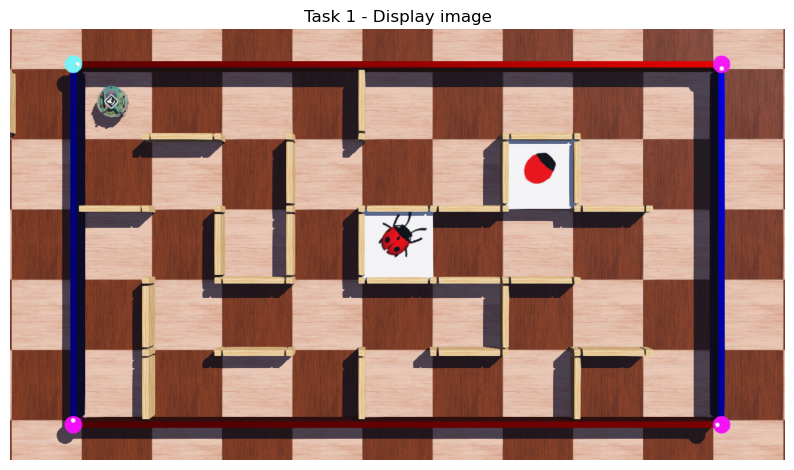

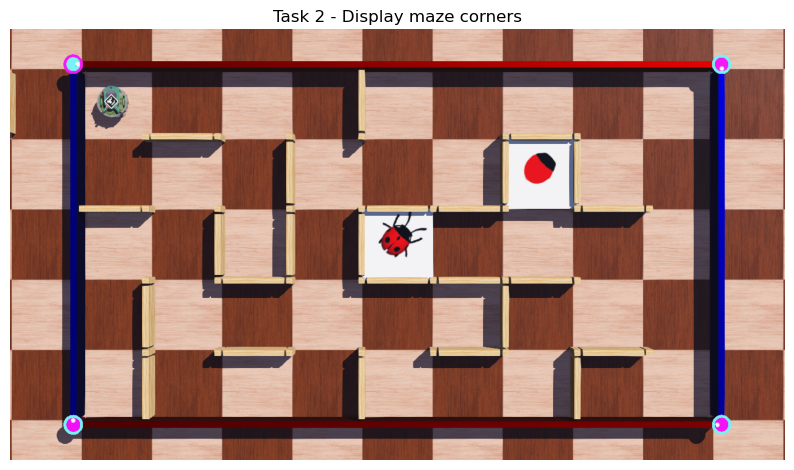

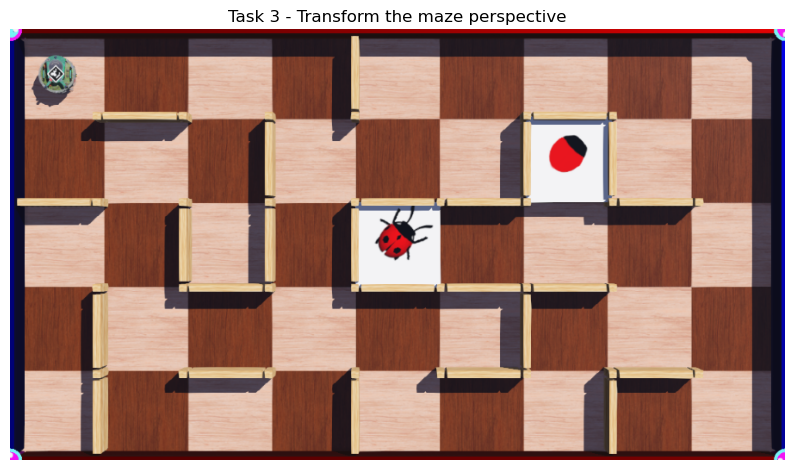

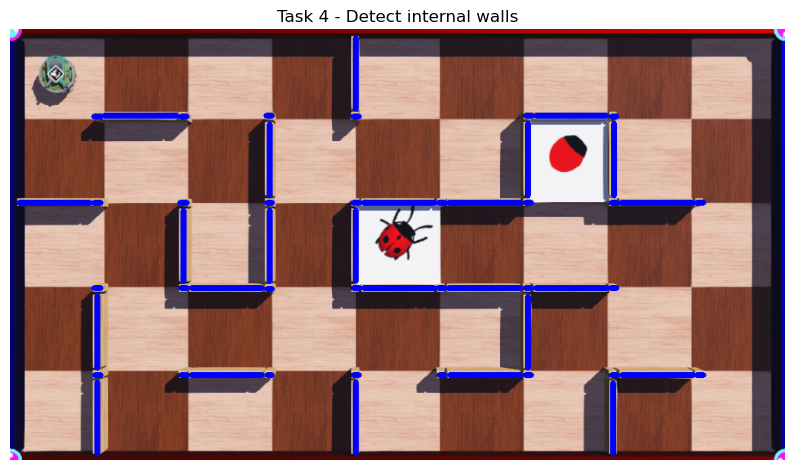

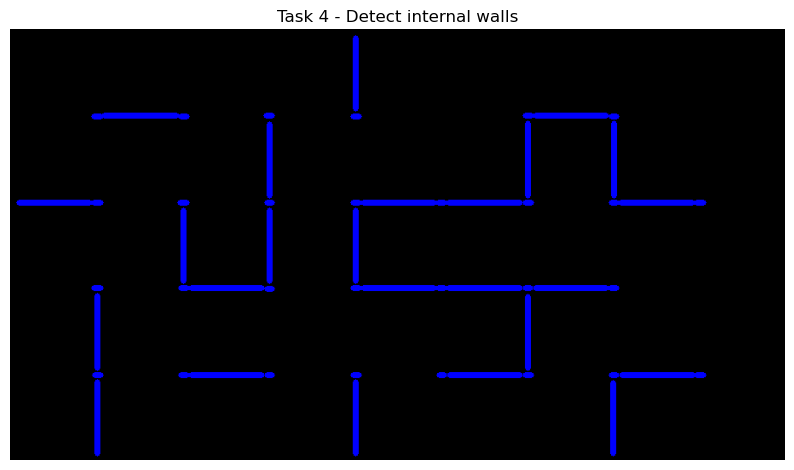

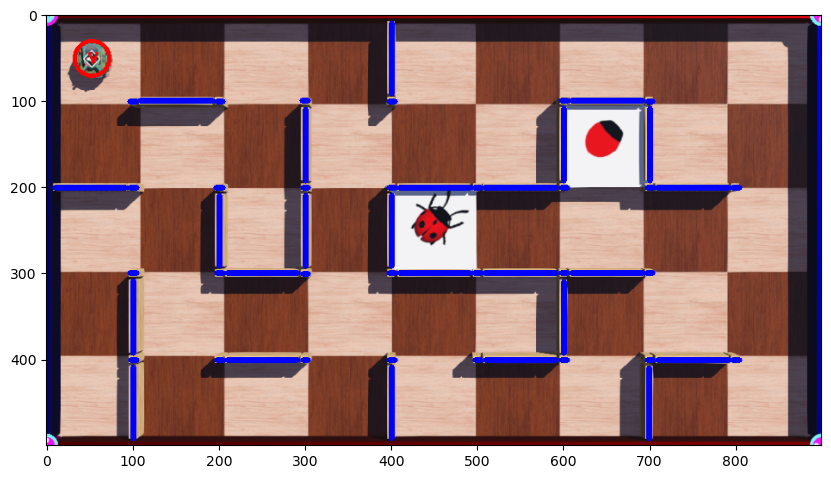

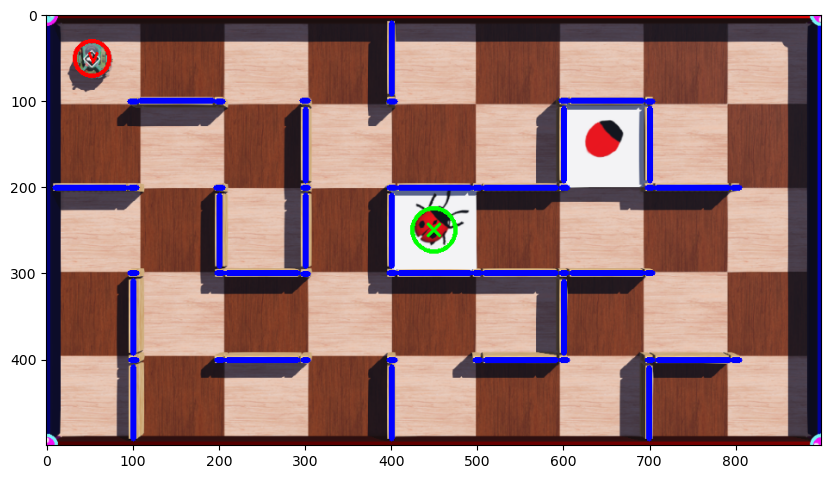

In [12]:
def run(default, trackMotion):
    if default:
        maze_img, robot_img, target_img = task1(plot=True)
        maze_corners, corners, flipped = task2(maze_img, plot=True)
        maze_transformed = task3(maze_corners, corners, plot=True)
        maze_walls, _ = task4(maze_transformed, plot=True)
        maze_robot, robot_loc = task5(maze_walls, robot_img, flipped, plot=True)
        maze_target, target_loc = task6(maze_robot, plot=True)
        task7(maze_target, robot_loc, target_loc)
    elif trackMotion:
        trackRobot(MAZE_VIDEO_PATH)

# Run the program
# True, False = Runs normal tasks
# False, True = Runs only motion tracking
# True, True = Runs both normal tasks and motion tracking
run(True, False)